In [2]:
import sys 
import os
import cobra
import cplex 
import libsbml
import copy
from pathlib import Path
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import xlsxwriter
import path 
import pandas as pd
import numpy as np
from scipy.stats import zscore
from itertools import combinations
from scipy.stats import kruskal, mannwhitneyu
import multiprocessing
from itertools import combinations, product
from multiprocessing import Pool
from sklearn.decomposition import PCA
import mplcursors


from sklearn.linear_model  import LinearRegression

#Change working dir first, ty ChatGPT, much loves
cwd = os.getcwd()
# Split the path into a list of directories
directories = cwd.split(os.sep)
# Remove the last two directories from the list
directories = directories[:-2]
# Join the directories back into a path
new_cwd = os.sep.join(directories)
# Change the current working directory to the new path
os.chdir(new_cwd)

sys.path.append("./src/")

import model_initialize as mi
import model_manipulation as mm


#Set solver to gurobi
config = cobra.Configuration()
config.solver = 'glpk'

#Read 2-cell model
wt_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
trans_model = cobra.io.read_sbml_model("./model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6


#Add trans reactions to trans_model
mi.add_trans_reactions(trans_model)


Pipeline breakdown:

Load CSVs to a memory saving format first

1.
Run convergence statistics on each and generate plots to assess total convergence stats for each CSV. These will include tests such as the Geweke statistic. 
Afterwards get only the flux names of those reactions that have converged
Run pairwise Kruskal-wallis tests per CSV using the above list of converged reactions
Identify each reaction with significant and non-significant distributions each

Generate histograms/probability densities for relevant reactions with significantly different distributions with WT and Trans models

2. Flux coupling analysis
Check which fluxes are coupled with each otehr and identify which fluxes are then related to each other, particularly Carbon Fixation reactions in the BS cell such as Rubisco and the DM_Phloem reactions. 


In [3]:
'''This code block contains functions that we need to use to analyze our flux sampling experiment. 
These include tests to check for convergence, for autocorrelation, as well as for pairwise comparisons of fluxes between
parametization regimens (WT, TR, as well as 3 light conditions) and a script to determine whether fluxes are
coupled with each other. Lastly, I also tried PCA to determine which reactions contribute most to the variance of each null space distribution per
sampling run.
'''

def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name


def load_csv_and_cleanup(filename, tol=1e-7):
    # Load the CSV file
    df = pd.read_csv(filename)

    # Remove columns with a mean below tolerance
    mean_values = df.mean()
    columns_to_remove = mean_values[abs(mean_values) < tol].index
    df = df.drop(columns=columns_to_remove)

    # Fix the indices
    df.reset_index(drop=True, inplace=True)
    print(df.shape)

    return df    

    


def compare_pair(reaction, df1, df2, significance_threshold):
    """
    Compare the flux distributions of a pair of columns from two dataframes using the Kruskal-Wallis test.

    :param pair: Tuple containing the pair of column names.
    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test.
    :return: The pair and the result of the Kruskal-Wallis test.
    """
    sample1 = df1[reaction]
    sample2 = df2[reaction]
    H, pval = kruskal(sample1, sample2)
    return H, pval

def compare_flux_distributions(df1, df2, significance_threshold=0.05):
    """
    Compare the flux distributions of each pair of columns from two dataframes using the Kruskal-Wallis test.

    :param df1: The first dataframe.
    :param df2: The second dataframe.
    :param significance_threshold: The significance threshold to use for the Kruskal-Wallis test (default: 0.05).
    :return: A list of pairs with significantly different distributions.
    """
    common_columns = set(df1.columns) & set(df2.columns)
    
    pool = multiprocessing.Pool()
    sig_results = []
    non_sig_results = []
    
    for rxn in common_columns:
        H, kw_pval = compare_pair(rxn, df1, df2, significance_threshold) #This does the Kruskal-Wallis part
        if kw_pval <= significance_threshold:
            sig_results.append(rxn)
        else:
            non_sig_results.append(rxn)
            
    #Sort the outputs before returning
    sig_results.sort()
    non_sig_results.sort()
            
    
    return sig_results, non_sig_results



#The script above is used for flux coupling using the opened CSV file as input and outputs 3 lists:
#positively correlated, neg. correlated and uncoupled reactions


#This is for visualization
def generate_histograms(dataframe1, dataframe2, column_name):
    # Create subplots for two histograms
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    # Histogram for dataframe1
    axes[0].hist(dataframe1[column_name], bins=10, color='skyblue')
    axes[0].set_title(f'Histogram of {column_name}')
    axes[0].set_xlabel(column_name)
    axes[0].set_ylabel('Frequency')

    # Histogram for dataframe2
    axes[1].hist(dataframe2[column_name], bins=10, color='lightgreen')
    axes[1].set_title(f'Histogram of {column_name}')
    axes[1].set_xlabel(column_name)
    axes[1].set_ylabel('Frequency')

    # Adjust spacing between subplots
    plt.tight_layout()

    # Show the histograms
    plt.show()

    
def generate_stacked_histogram(dataframes, column_name,histtype='bar'):
    fig = plt.figure()
    
    # Concatenate the column data from all dataframes into a single series
    
    df_name = list()
    
    
    for dfs in dataframes:
    # Create the stacked histogram
        if column_name in dfs.columns:

            plt.hist(dfs[column_name], bins=33, alpha=0.45, stacked=True, density=False,histtype=histtype)
            df_name.append(get_df_name(dfs))
        else:
            pass
    
    
    
    
    # Set plot title and labels
    plt.title(f"Stacked Histogram for Column: {column_name}")
    plt.xlabel(column_name)
    plt.ylabel("Counts")
    plt.legend(df_name)
 
    
    plt.figure().set_figheight(1)
    
    return fig

def plot_scatter_regression(df, column_x, column_y):
    """
    Generates a scatterplot and a linear regression line between two columns in a dataframe.

    Parameters:
        - df (pandas.DataFrame): The input dataframe.
        - column_x (str): The column name for the X-axis.
        - column_y (str): The column name for the Y-axis.
    """

    # Extract X and Y values from the dataframe
    X = df[column_x].values.reshape(-1, 1)
    Y = df[column_y].values

    # Fit linear regression model
    regression = LinearRegression()
    regression.fit(X, Y)

    # Predict Y values based on the regression line
    Y_pred = regression.predict(X)

    # Plot the scatterplot and regression line
    plt.scatter(X, Y, color='blue', label='Actual')
    plt.plot(X, Y_pred, color='red', label='Regression Line')
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.title('Scatterplot with Linear Regression Line')
    plt.legend()
    plt.show()


    
    
#These functions are for generating PCA plots and other corollary analyses

def merge_dataframes(dataframes, names):
    merged_df = pd.DataFrame()
    
    for i, df in enumerate(dataframes):
        # Get the corresponding name from the names list
        df_name = names[i]
        
        # Add a new column with the dataframe name
        df['sample'] = df_name
        
        # Merge dataframes
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # Remove NAs
    merged_df = merged_df.fillna(1e-7)
    
    return merged_df

def generate_pca_plot(dataframe):
    numeric_columns = dataframe.select_dtypes(include=[np.number]).columns
    X = dataframe[numeric_columns].values

    pca = PCA(n_components=3)

    components = pca.fit_transform(X)

    # Extract dataframe names
    dataframe_names = dataframe['sample'].unique()

    # Generate plot with different colors for each dataframe
    colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow']  # Add more colors if needed

    #Generate figure and subplot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for i, name in enumerate(dataframe_names):
        indices = dataframe['sample'] == name
        ax.scatter(components[indices, 0], components[indices, 1], label=name, c=colors[i])

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.legend()
    
    mplcursors.cursor(hover=True)
    plt.show()
 
    #export PCA to determine component variance
    
    pca_fit = pca.fit(X)
    
    return pca_fit

def select_significant_features(pca, feature_names, top_n):
    loadings = pca.components_
    abs_loadings = np.abs(loadings)
    feature_contribution = np.sum(abs_loadings, axis=0)
    sorted_features = feature_names[np.argsort(feature_contribution)[::-1]]
    selected_features = sorted_features[:top_n]
    return selected_features

def plot_selected_features_heatmap(pca, feature_names, selected_features):
    loadings = pca.components_
    selected_indices = [np.where(feature_names == feature)[0][0] for feature in selected_features]
    selected_loadings = loadings[:, selected_indices]

    plt.figure(figsize=(10, 6))
    sns.heatmap(selected_loadings, cmap='coolwarm', annot=False, xticklabels=selected_features)
    plt.xlabel('Selected Features')
    plt.ylabel('Principal Components')
    plt.title('Loadings Heatmap of Selected Features')
    plt.show()


    
def visualize_correlation_matrix(df, sort_by=None, ascending=False):
    """
    Calculates and visualizes the correlation matrix based on flux measurements in a dataframe.

    Parameters:
        - df (pandas.DataFrame): The input dataframe containing flux measurements.
        - sort_by (str or None): Column name to sort the correlation matrix by. Default is None.
        - ascending (bool): Whether to sort in ascending order. Default is False.
    """

    # Calculate the correlation matrix
    correlation_matrix = df.corr()

    # Sort the correlation matrix if sort_by is specified
    if sort_by is not None:
        correlation_matrix = correlation_matrix.sort_values(by=sort_by, ascending=ascending)

    # Create a heatmap of the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', square=True)

    # Set plot title
    plt.title('Correlation Matrix')

    # Display the heatmap
    plt.show()

def filter_correlation_pairs(correlation_matrix, threshold, filter_elements):
    """
    Filters out specific pairs in the correlation matrix based on a specified absolute value threshold,
    removes pairs that share columns, removes symmetrical results, and returns the rows where the filter elements are found in either of the two variable columns.

    Parameters:
        - correlation_matrix (pandas.DataFrame): The correlation matrix.
        - threshold (float): The absolute value threshold to filter the correlation coefficients.
        - filter_elements (list): The elements to filter out from the correlation matrix.

    Returns:
        - filtered_pairs (pandas.DataFrame): The table showing the filtered pairs and their correlation coefficients,
                                             where the filter elements are found in either of the two variable columns,
                                             with symmetrical results removed.
    """
    # Filter out pairs based on the threshold
    filtered_pairs = correlation_matrix.unstack().reset_index()
    filtered_pairs = filtered_pairs.rename(columns={'level_0': 'Variable A', 'level_1': 'Variable B', 0: 'Correlation'})
    filtered_pairs = filtered_pairs[filtered_pairs['Correlation'].abs() >= threshold]

    # Remove pairs that share columns
    filtered_pairs = filtered_pairs[~(filtered_pairs['Variable A'] == filtered_pairs['Variable B'])]

    # Remove symmetrical results
    filtered_pairs = filtered_pairs[filtered_pairs['Variable A'] < filtered_pairs['Variable B']]

    # Filter rows where the filter elements are found in either of the two variable columns
    filtered_pairs = filtered_pairs[(filtered_pairs['Variable A'].isin(filter_elements)) | (filtered_pairs['Variable B'].isin(filter_elements))]
    
    # Sort the filtered pairs by correlation coefficient in descending order
    filtered_pairs = filtered_pairs.sort_values('Correlation', ascending=False)
    
    filtered_pairs = filtered_pairs.reset_index()
    

    return filtered_pairs

def check_column_exists(dataframes, column_name):
    for df in dataframes:
        if column_name in df.columns:
            return True
    return False



In [16]:

wt_250 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/WT_250.csv' ,tol=1e-4)
wt_750 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/WT_750.csv' ,tol=1e-4)
wt_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/WT_1500.csv',tol=1e-4)
tr_250 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/TR_250.csv',tol=1e-4)
tr_750 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/TR_750.csv', tol=1e-4)
tr_1500 = load_csv_and_cleanup('./flux_results/flux_sampling/8th_attempt_fixed_transporter_issues/10k_samples/TR_1500.csv',tol=1e-4)


    

    

df_list = [wt_250, wt_750, wt_1500, tr_250, tr_750, tr_1500]
names = ['wt_250', 'wt_750', 'wt_1500', 'tr_250', 'tr_750', 'tr_1500']
wt_list = [wt_250, wt_750, wt_1500]
tr_list = [tr_250, tr_750, tr_1500]
_250_list = [wt_250,tr_250]
_750_list = [wt_750,tr_750]
_1500_list=[wt_1500,tr_1500]


(10008, 697)
(10008, 814)
(10008, 750)
(10008, 1036)
(10008, 1119)
(10008, 1185)


In [7]:


def summarizer(summary_type, group):
    if summary_type == "mean":
        return group.mean()
    elif summary_type == "median":
        return group.median(numeric_only=True)
    elif summary_type == "geometric_mean":
        return np.exp(np.log(group).mean())
   

def merge_dataframes_for_summary(dataframes, names, summary_type):
    merged_df = pd.DataFrame()
    
    for i, df in enumerate(dataframes):
        # Get the corresponding name from the names list
        df_name = names[i]
        
        # Add a new column with the dataframe name
        df['sample'] = df_name
        
        # Merge dataframes
        if merged_df.empty:
            merged_df = df
        else:
            merged_df = pd.concat([merged_df, df], ignore_index=True)
    
    # Remove NAs
    merged_df = merged_df.fillna(0)
    
    # Split 'sample' column into 'sample' and 'ppfd'
    # merged_df[['sample', 'ppfd']] = merged_df['sample'].str.split('_', expand=True)  # You can remove this line
    
    # Summarize the dataframe per column
    summary_df = merged_df.groupby(['sample']).apply(lambda group: summarizer(summary_type, group.drop(['sample'], axis=1))).reset_index()
    
    # Pivot the summarized data to have separate columns for each sample
    summary_pivot = summary_df.T
    
    # Set the first row as the new column headers
    summary_pivot.columns = summary_pivot.iloc[0]

        # Remove the original "sample" row
    summary_pivot = summary_pivot.iloc[1:]

    # Rename the index axis
    summary_pivot = summary_pivot.rename_axis(columns=None)
    
    #Rearrange the columns based on the desired order
    summary_pivot = summary_pivot.reindex(columns=names)

    
    
    
    return summary_pivot


#Save the dfs to a spreadsheet
summ_stats = ['mean','median','geometric_mean']

#Create summary tables for later viewing
filepath = './flux_results/For_final_analysis/Sampling_summaries/'
filename = 'summary_statistics_flux_sampling_10112023'
workbook = mm.create_xlsx(filename, filepath)
for i in summ_stats:
    summ_df = merge_dataframes_for_summary(df_list, names, i)
    summ_df.to_excel(workbook, sheet_name=i)
 
workbook.close()


Successfully generated summary_statistics_flux_sampling_10112023-20231111-17:43 in ./flux_results/For_final_analysis/Sampling_summaries/summary_statistics_flux_sampling_10112023-20231111-17:43.xlsx


/home/articulatus/anaconda3/envs/RiceMM/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/articulatus/anaconda3/envs/RiceMM/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/articulatus/anaconda3/envs/RiceMM/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/articulatus/anaconda3/envs/RiceMM/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/home/articulatus/anaconda3/envs/RiceMM/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/home/articulatus/anaconda3

First, print out all active reactions in both M and BS cells and their mean flux sums, just to show the rough disparity between the network fluxes between the two compartments

In [8]:
#Print out active reactions in each compartment
def compare_lists(list1, list2):
    # Function to get the first half of an item without the suffix
    def get_first_half(item):
        return item.split('_')[0]

    # Create sets of the first halves of items in each list
    first_half_set1 = set(get_first_half(item) for item in list1)
    first_half_set2 = set(get_first_half(item) for item in list2)

    # Find unique items in list1
    unique_list1 = [item for item in list1 if get_first_half(item) not in first_half_set2]

    # Find unique items in list2
    unique_list2 = [item for item in list2 if get_first_half(item) not in first_half_set1]

    output_list = list()
    
    output_list.append(unique_list1)
    output_list.append(unique_list2)
    return unique_list1, unique_list2
    
def get_flux_sums(df,rxn_list):
    '''This function gets the net absolute sum of fluxes using the means of each reaction column, 
    given a list denoting which particular compartment are we looking into (i.e. M vs BS cells) '''
    net_sum = 0
    
    for i in df.columns:
        if i in rxn_list:
            abs_mean = abs(np.mean(df[i]))
            net_sum += abs_mean
            
    return net_sum
            

    import pandas as pd


    
# Initialize lists to hold the data
df_name_list = []
active_reactions_list = []
m_reactions_list = []
bs_reactions_list = []
m_unique_rxns_list = []
bs_unique_rxns_list = []
m_net_sum_list = []
bs_net_sum_list = []

# Iterate through the data
for i in range(len(df_list)):
    dfs = df_list[i]
    df_name = names[i]
    
    active_reactions = len(dfs.columns)
    m_rxns = [rxns for rxns in dfs.columns if "_M" in rxns]
    bs_rxns = [rxns for rxns in dfs.columns if "_BS" in rxns]
    m_net_sum = get_flux_sums(dfs, m_rxns)
    bs_net_sum = get_flux_sums(dfs, bs_rxns)
    m_list, bs_list = compare_lists(m_rxns, bs_rxns)
    
    # Append data to lists
    df_name_list.append(df_name)
    active_reactions_list.append(active_reactions)
    m_reactions_list.append(len(m_rxns))
    bs_reactions_list.append(len(bs_rxns))
    m_unique_rxns_list.append(len(m_list))
    bs_unique_rxns_list.append(len(bs_list))
    m_net_sum_list.append(m_net_sum)
    bs_net_sum_list.append(bs_net_sum)

# Create a DataFrame from the lists
data = {
    'DataFrame Name': df_name_list,
    'Active Reactions': active_reactions_list,
    'M Reactions': m_reactions_list,
    'BS Reactions': bs_reactions_list,
    'Unique Reactions in M': m_unique_rxns_list,
    'Unique Reactions in BS': bs_unique_rxns_list,
    'Net Flux Sum (M Cell)': m_net_sum_list,
    'Net Flux Sum (BS Cell)': bs_net_sum_list
}

result_df = pd.DataFrame(data)

# Save the DataFrame to a spreadsheet
result_df.to_excel('./For_final_analysis/Spreadsheets/Flux_sum_spreadsheet_11112023.xlsx', index=False)  # Change the filename and format as needed


PART 1: PCA
This is an attempt to use Principal component analysis to analyze the variance between the sample distributions. I am particularly interested on which particular reactions contribute most to the variance when all of the samplings have been pooled into a single large dataframe. 

This is just a test though since I'm not too sure what I am doing



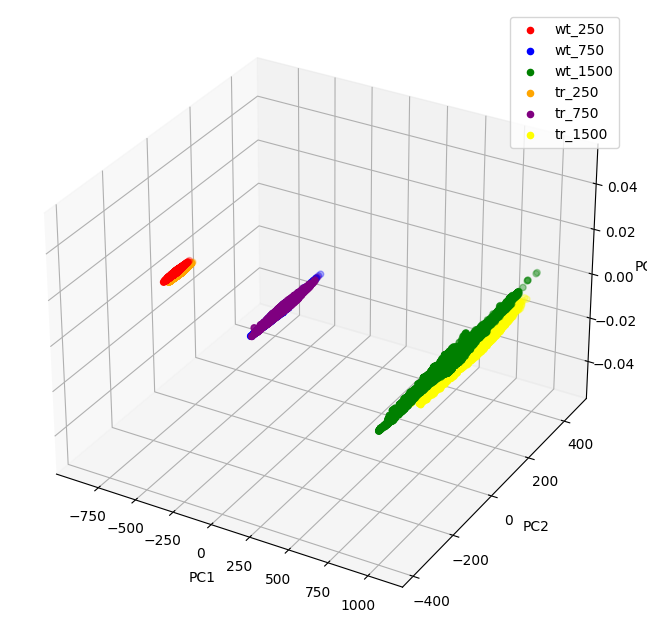

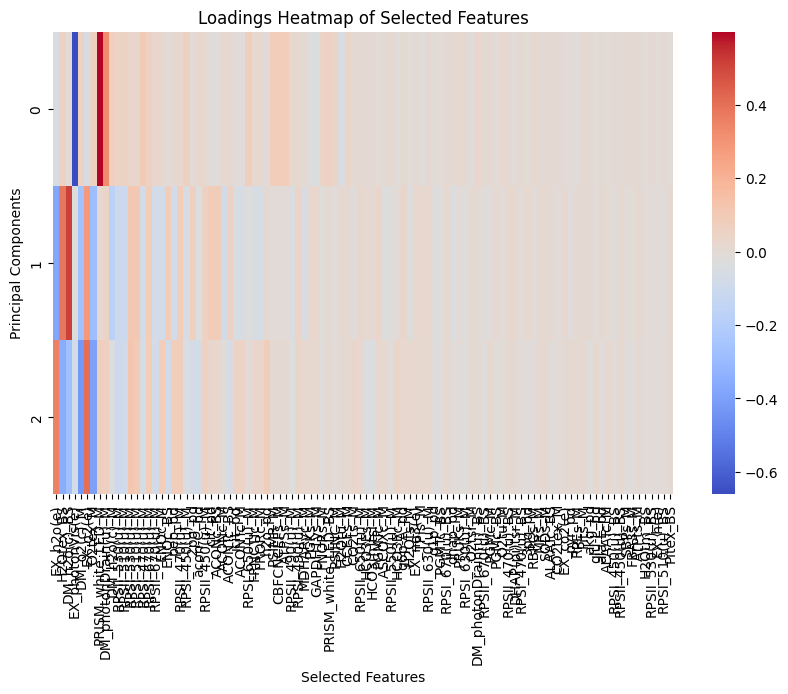

In [98]:

merged_df = merge_dataframes(df_list, names)
    
flux_sampling_pca = generate_pca_plot(merged_df)

top_contribs = select_significant_features(flux_sampling_pca, merged_df.columns, 100)

plot_selected_features_heatmap(flux_sampling_pca, merged_df.columns, top_contribs)

STAT NO. 2: Pairwise comparison of flux distributions
This offers a more comprehensive view on which reactions have a different flux distribution in between samples. The test used for this stat is the Kruskal-Wallis ranked test, which is a non-parametric test typically used for flux sampling to compare fluxes between groups


In [9]:
kw_thresh=1e-3

wt_250_750_sig, wt_250_750_non_sig =compare_flux_distributions(wt_250, wt_750, significance_threshold=kw_thresh)
wt_250_1500_sig, wt_250_1500_non_sig =compare_flux_distributions(wt_250, wt_1500, significance_threshold=kw_thresh)
wt_750_1500_sig, wt_750_1500_non_sig =compare_flux_distributions(wt_750, wt_1500, significance_threshold=kw_thresh)


tr_250_750_sig, tr_250_750_non_sig = compare_flux_distributions(tr_250, tr_750, significance_threshold=kw_thresh)
tr_750_1500_sig, tr_750_1500_non_sig = compare_flux_distributions(tr_750, tr_1500, significance_threshold=kw_thresh)
tr_250_1500_sig, tr_250_1500_non_sig = compare_flux_distributions(tr_250, tr_1500, significance_threshold=kw_thresh)

wt_tr_250_sig, wt_tr_250_non_sig = compare_flux_distributions(wt_250, tr_250, significance_threshold=kw_thresh)
wt_tr_750_sig, wt_tr_750_non_sig = compare_flux_distributions(wt_750, tr_750, significance_threshold=kw_thresh)
wt_tr_1500_sig, wt_tr_1500_non_sig = compare_flux_distributions(wt_1500, tr_1500, significance_threshold=kw_thresh)

wt_invariant_fluxes = set(wt_250_750_non_sig) & set(wt_750_1500_non_sig)
#no invariant fluxes between all samples WT

tr_invariant_fluxes = set(tr_250_750_non_sig) & set(tr_750_1500_non_sig)
#0 invariant fluxes

wt_tr_250_750_invariant_fluxes = set(wt_tr_250_non_sig) & set(wt_tr_750_non_sig)

wt_tr_750_1500_invariant_fluxes = set(wt_tr_750_non_sig) & set(wt_tr_1500_non_sig)

wt_tr_250_1500_invariant_fluxes = set(wt_tr_250_non_sig) & set(wt_tr_1500_non_sig)

data = {
    'Case': ['wt_tr_250_sig', 'wt_tr_250_non_sig', 'wt_tr_750_sig', 'wt_tr_750_non_sig', 'wt_tr_1500_sig', 'wt_tr_1500_non_sig'],
    'Length': [len(wt_tr_250_sig), len(wt_tr_250_non_sig), len(wt_tr_750_sig), len(wt_tr_750_non_sig), len(wt_tr_1500_sig), len(wt_tr_1500_non_sig)]
}

df = pd.DataFrame(data)

df

,Case,Length
0,wt_tr_250_sig,1005
1,wt_tr_250_non_sig,3
2,wt_tr_750_sig,1071
3,wt_tr_750_non_sig,5
4,wt_tr_1500_sig,697
5,wt_tr_1500_non_sig,16


In [10]:
wt_tr_1500_sig

['1Dgali_pd',
 '3PG(pi)tsr_BS',
 '3PG(pi)tsr_M',
 '3pg_pd',
 '4ABUTts_BS',
 '4ABUTts_M',
 'A4GALTc_BS',
 'ABTA1m_BS',
 'ABTA1m_M',
 'AC5GSAtr_M',
 'ACALDHc_BS',
 'ACALDHc_M',
 'ACALDHm_BS',
 'ACALDHs_BS',
 'ACALDtm_BS',
 'ACCOAtm_BS',
 'ACCOAtm_M',
 'ACCOAts_BS',
 'ACCOAts_M',
 'ACCOAtx_BS',
 'ACCOAtx_M',
 'ACGLUts_M',
 'ACHBSs_BS',
 'ACONTc_BS',
 'ACONTc_M',
 'ACONTm_BS',
 'ACONTm_M',
 'ACONm_BS',
 'ACONm_M',
 'ACSs_BS',
 'ACSs_M',
 'ACSx_BS',
 'ACtm_BS',
 'ACts_BS',
 'ACts_M',
 'ACtx_BS',
 'ADK1c_BS',
 'ADK1s_BS',
 'ADK1s_M',
 'ADPARTs_BS',
 'ADSALs_BS',
 'ADSSs_BS',
 'AGALSc_BS',
 'AGATm_BS',
 'AGATm_M',
 'AGGPRc_M',
 'AGKc_M',
 'AGSs_BS',
 'AGSs_M',
 'AKGtx_BS',
 'AKGtx_M',
 'ALAATc_BS',
 'ALAATc_M',
 'ALAt2m_BS',
 'ALAt2m_M',
 'AMETAHYCSTc_BS',
 'AMETt2s_BS',
 'ANXANEOys_BS',
 'AOOAs_BS',
 'AOTAs_M',
 'AOXm_BS',
 'AOXm_M',
 'APLs_BS',
 'APLs_M',
 'ARGDHTs_BS',
 'ARGDHTs_M',
 'ARGDHs_BS',
 'ARGDHs_M',
 'ARGDIc_BS',
 'ARGDm_BS',
 'ARGOAT2s_BS',
 'ARGOAT2s_M',
 'ARGSL1c_BS',
 'ARGSL1

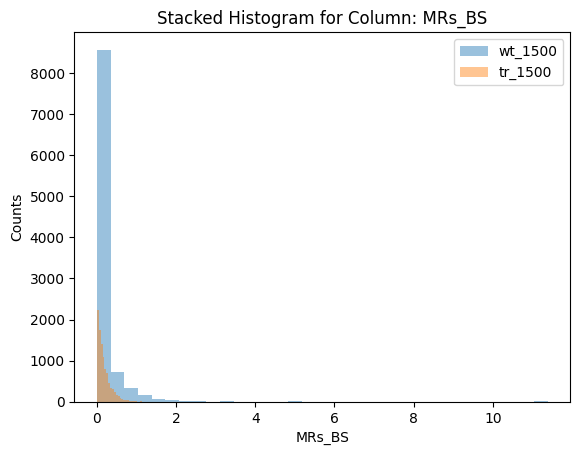

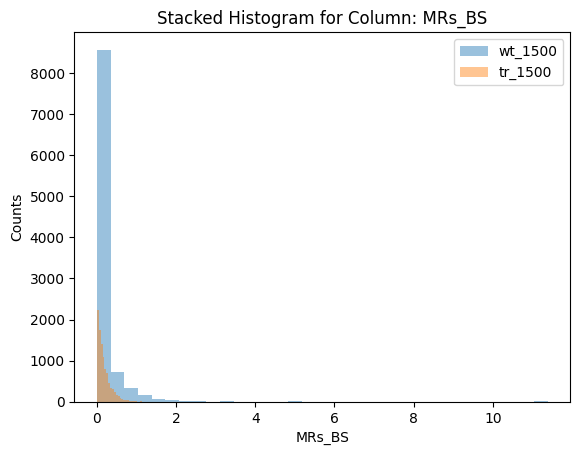

<Figure size 640x100 with 0 Axes>

In [15]:
generate_stacked_histogram(_1500_list, 'MRs_BS')

In [12]:
#Which reaction eroups are generally not perturbed by the addition of light?
reaction_group_list_1500 = list()
for rxn in wt_tr_1500_non_sig:
    reaction = trans_model.reactions.get_by_id(rxn)
    # print('reaction id: ', reaction.id)
    # print('reaction name: ', reaction.name)
    groups = reaction.notes.get('SUBSYSTEM', '')
    # print('reaction groups: ', groups)
    if groups not in reaction_group_list_1500:
        reaction_group_list_1500.append(groups)
reaction_group_list_1500

['Plasmodesmatal Transport',
 'Glyoxylate Cycle',
 'Fermentation',
 'Glycine, serine and threonine metabolism',
 'Transport (Plastidic)',
 'Nitrogen metabolism',
 'Glycolysis/Gluconeogensis']

In [34]:
#Which reaction groups are generally not perturbed by the addition of light?
reaction_group_list_750 = list()
for rxn in wt_tr_750_non_sig:
    reaction = trans_model.reactions.get_by_id(rxn)
    # print('reaction id: ', reaction.id)
    # print('reaction name: ', reaction.name)
    groups = reaction.notes.get('SUBSYSTEM', '')
    # print('reaction groups: ', groups)
    if groups not in reaction_group_list_750:
        reaction_group_list_750.append(groups)
reaction_group_list_750

['Lysine metabolism',
 'Glycolysis/Gluconeogensis',
 'Arginine and proline metabolism',
 'Transport (Plastidic)',
 'Nitrogen metabolism',
 'Starch and sucrose metabolism (Sucrose)',
 'Calvin cycle',
 'Plasmodesmatal Transport']

In [35]:
reaction_group_list_250 = list()
for rxn in wt_tr_250_non_sig:
    reaction = trans_model.reactions.get_by_id(rxn)
    # print('reaction id: ', reaction.id)
    # print('reaction name: ', reaction.name)
    groups = reaction.notes.get('SUBSYSTEM', '')
    # print('reaction groups: ', groups)
    if groups not in reaction_group_list_250:
        reaction_group_list_250.append(groups)
reaction_group_list_250

['Photorespiration',
 'Lysine metabolism',
 'Exchange Reactions',
 'Calvin cycle',
 'Transport (Extracellular)',
 'Transport (Mitochondrial)',
 'Transport (Plastidic)',
 'Spectral decomposition',
 'Primary Cell Wall Metabolism (Galactose metabolism)',
 'Plasmodesmatal Transport',
 'Maintainance reaction']

In [37]:

reaction_group_list_250 = list()
for rxn in wt_tr_250_non_sig:
    reaction = trans_model.reactions.get_by_id(rxn)
    groups = reaction.notes.get('SUBSYSTEM', '')
    if groups == 'Calvin cycle' or groups == 'Calvin Cycle': 
        print('reaction id: ', reaction.id)
        print('reaction name: ', reaction.name)

        print('reaction groups: ', groups)
    if groups not in reaction_group_list_250:
        reaction_group_list_250.append(groups)
reaction_group_list_250

reaction id:  FBA3s_BS
reaction name:  Sedoheptulose 1,7-bisphosphate D-glyceraldehyde-3-phosphate-lyase
reaction groups:  Calvin cycle
reaction id:  SBPs_BS
reaction name:  Sedoheptulose-bisphosphatase
reaction groups:  Calvin cycle


['Photorespiration',
 'Lysine metabolism',
 'Exchange Reactions',
 'Calvin cycle',
 'Transport (Extracellular)',
 'Transport (Mitochondrial)',
 'Transport (Plastidic)',
 'Spectral decomposition',
 'Primary Cell Wall Metabolism (Galactose metabolism)',
 'Plasmodesmatal Transport',
 'Maintainance reaction']

STAT NO 3: CORRELATION MATRICES
This code block is used to generate correlation matrices for the purpose of inferring which reactions are directly correlated with each other or not.

In [28]:
#Generation of Correlation Matrices 

wt_250_corr = wt_250.corr()
wt_750_corr = wt_750.corr()
wt_1500_corr = wt_1500.corr()

tr_250_corr = tr_250.corr()
tr_750_corr =  tr_750.corr()
tr_1500_corr = tr_1500.corr()

/tmp/ipykernel_17580/2408425802.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wt_250_corr = wt_250.corr()
/tmp/ipykernel_17580/2408425802.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wt_750_corr = wt_750.corr()
/tmp/ipykernel_17580/2408425802.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  wt_1500_corr = wt_1500.corr()
/tmp/ipykernel_17580/2408425802.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it

Generation of histograms and detailed analysis of Individual reactions at different light levels

These code blocks are for the analysis of the following reactions:
- Glycine Decarboxylase Activity
- Aminomethyltransferase Activity
- Correlation analysis for GLYDHDm for trans reactions (to identify which reactions are closely related to it then identify which contributes strongly to its reduction @ high levels)


#Factors that may strongly affect Glycine decarboxylase activity (to check)
#Regeneration of Lipoylprotein (which is shown to have a direct correlation with Glycine Decarboxylase activity. (1.00 CCorr)
#Serine plasmodesmatal export (1.0 corr)
#Glycine Decarboxylase activity in the other compartment (
#Serine Hydroxymethyltransferase (production of Serine via transhydroxymethylation from MethyleneTHF (1.00 Corr)


- NH4 transport to the Mitochondria (which in turn is linked towards the C2 cycle via the Aminomethyltransferase reaction) (0.950757 corr coef)

Findings:
- Glycine Decarboxylase is modulated in the trans-parametrized models without explicit constraints, showing a lower reaction flux in the M comnpartment compared to the BS comparement.
- Reaction becomes decoupled only at high light while  showing close distributions at low to medium light levels -- although the KW test reports significant differences in the distribution between the two parametizations @ 95% confidence interval. I'll check with 99.99% interval instead
    - It is coupled in low and medium lights and only diverges @ high light treatments. 
- The most likely culprit for the decrease in Gly DC activity in M cells is the increase in flux of NH4 to BS cell Mit. However, it does not correspond with an increase in GLyDH activity in the BS cell meaning that it is being used up in other reactions. Other reactions that were found to increase is the import of Serine into the M cell which is @ equilibrium but slightly skewed towards BS cell export in the Trans model.


Question: 
- Is dihydrolipoylprotein:NAD+ oxidoreductase skewed towards NAD+ reduction or Oxidation? -- (It is towards regeneration of NADH) in both WT and TR.
- Therefore, is the reduction in glycine flux attributable to other reactions that reduce the NADH pool? Let's check all the reactions that make use of NADH in the M compartment.
- Based on the below plots, only Malate Dehydrogenase has a significantly varying distribution compared to the other reactions that involve NADH. The Trans model shows significantly lowered flux toward the oxidation of Malate and in turn the regeneration of NADH. The other reaction is the NADORm_M reaction, which corresponds to the NADH-coenzyme Q oxidoreductase reaction that consumes NADH to produce ubiquinol.

- These are the most likely culprits behind the reduced flux towards the GlyDC reaction as reduction of flux towards  Malate Dehydrogenase reaction reduces the Mitochondria. The **NADOR** reaction also consumes NADH to reduce Ubiquinone and has quite a high flux towards consumption of NADH.

Another question:
- Why is demand for q8h2 so high in the trans model? Let's check the reactions involving this metabolite.
    - Results show that the reaction CYOR (Cytochrome Oxidoreductase) has a significantly higher flux in TR than in WT. What does it mean?
    - I haven't modified this reaction so it has a significantly high imbalance (which I think is similar to other models)
    - Both Coenzyme Q and Cytochrome Oxidoreductase are significantly higher in high light conditions. How about in low and medium light conditions?
    
        - Only in high light conditions is this true. Meaning that the cytochrome fluxes are significantly higher in the Trans parametrized model for some reason, not sure why.
        I need to review literature on this, particularly this:
            "Mitochondria in photosynthetic cells: Coordinating redox control and energy balance" 
        Since the involved reactions are part of the ETC.
        
        I think this is also related towards the mitochondrial production of Citrate via CSm since it is also significantly upregulated in the Trans compared to the WT. This I think shows evidence of a significantly higher percent of photoassimilates being diverted to the Citric Acid Cycle. However, is it for the purpose of exporting citrate to the cytosol?
            - It is and it is equal to the amount of flux towards the Citrate Synthase, meaning that the flux towards the TCA cycle is hemicyclic and is for generating Redox potential in the Cytosol (Igamberdiev & Bykova, 2023). This may indicate a deficit in redox units in the Cytosol which necessitate its synthesis and export.
            - Increase in Malate dehydrogenase carrying capacity in Trans model may be observed to cause this change also, causing a net production of 
        
        
        
Things to check:

- Check if GOGAT enzymes are increased to compensate for NH3 increase due to higher 
        
Interesting!

What does this mean, though?

RESULTS:

1. Interestingly, it was found out that across all light conditions, the BS RBCL features highest flux ranges at medium light ranges (750 PPFD) than either in low or high light conditions. This relationship holds true for both Wild-type and Trans-parametrized models. 

2. Due to the carbon assimilation constraints, Rubisco becomes strongly decoupled at high light levels while featuring similar distributions at low and medium light parametrizations. However, it is also  detected to have a significantly different flux distributions when taking into account the results from the Kruskal-Wallis Test.

3. The list of decoupled reactions and their percentage based on the total active fluxes are as follows:







STAT NO. 3: FLUX COUPLING ANALYSIS

This is a technique that is used to detect couplings between specific reactions in a given model. This technique is elaborated upon by Price, SChellenberger & Palsson (2004) in which a randomly sampled solution space, appropriately constrained based on environmental and phenotypic conditions, allows us to infer pairwise relations between the flux solutions. In turn, this method allows us to see which reactions are strongly coupled with each other given a set of constraints. 

Here are some reactions that I am particularly interested in, since I've found that they were unexpectedly decoupled from each other:
-PSIINC_M
-RBPCs_BS


These are interesting results:

- I found out that Cyclic Electron Transport flow is increased under high light conditions in the TR model 

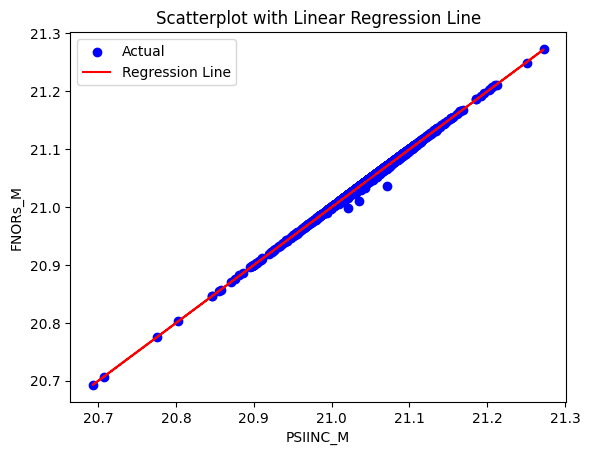

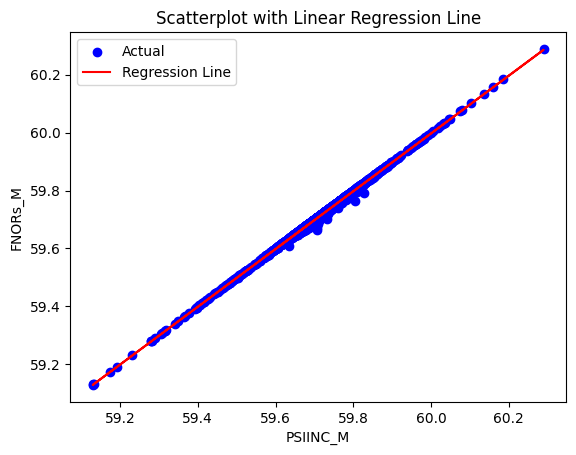

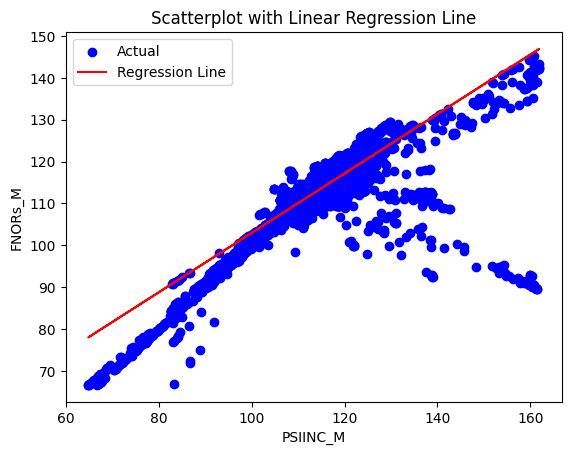

In [23]:
#This is a sample plot showing the correlation between Photosystem II and Ferredoxin-NADP reductase in the M cell and the BS cell 
#@ high light (Trans parametrized model)

plot_scatter_regression(wt_250, 'PSIINC_M', 'FNORs_M')
plot_scatter_regression(wt_750, 'PSIINC_M', 'FNORs_M')
plot_scatter_regression(wt_1500, 'PSIINC_M', 'FNORs_M')

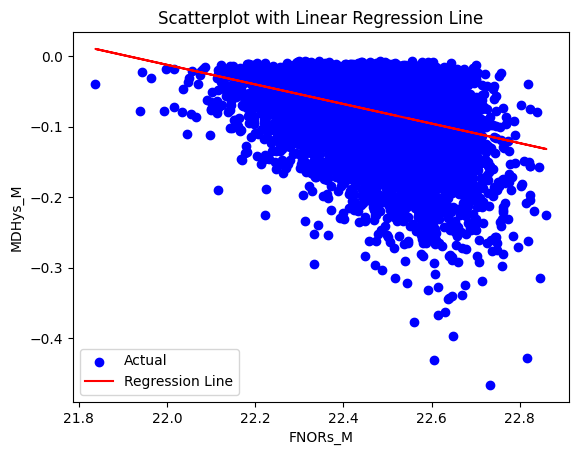

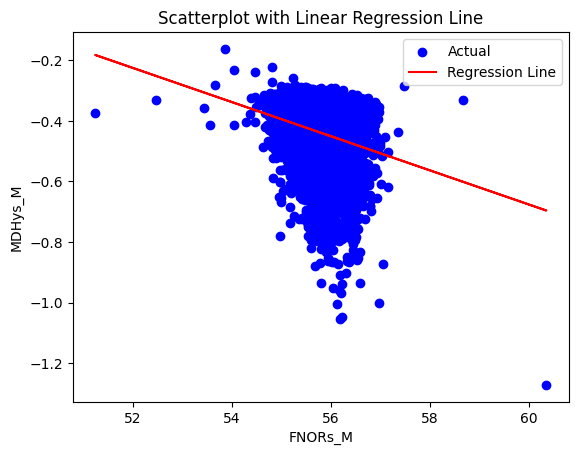

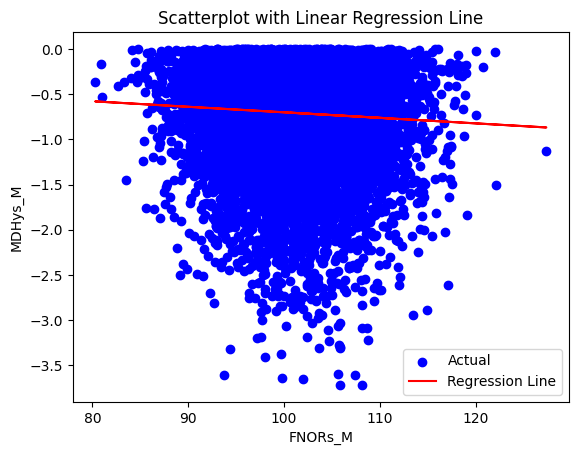

In [24]:
#This is a sample plot showing the correlation between Photosystem II and Ferredoxin-NADP reductase in the M cell and the BS cell 
#@ high light (Trans parametrized model)

plot_scatter_regression(tr_250, 'FNORs_M', 'MDHys_M')
plot_scatter_regression(tr_750, 'FNORs_M', 'MDHys_M')
plot_scatter_regression(tr_1500, 'FNORs_M', 'MDHys_M')

In [124]:
#This is a sample plot showing the correlation between Photosystem II and Ferredoxin-NADP reductase in the M cell and the BS cell 
#@ high light (Trans parametrized model)

plot_scatter_regression(tr_250,  'SUSc_M', 'SSs_M')
plot_scatter_regression(tr_750,  'SUSc_M', 'SSs_M')
plot_scatter_regression(tr_1500, 'SUSc_M', 'SSs_M')

KeyError: 'SUSc_M'

In [123]:
mdhs=filter_correlation_pairs(tr_750_corr, 0.0, ['SUSc_BS'])
mdhs

,index,Variable A,Variable B,Correlation


,index,Variable A,Variable B,Correlation


In [125]:
trans_model.reactions.SUSc_M

Reaction identifier,SUSc_M
Name,"Sucrose synthase, cytosolic"
Memory address,0x7f0c5561fd00
Stoichiometry,fru-B_c0 + udpg_c0 <=> h_c0 + sucr_c0 + udp_c0 beta-D-fructose + UDP-glucose <=> H+ + Sucrose + UDP
GPR,LOC_Os03g22120 or LOC_Os02g58480 or LOC_Os04g17650 or LOC_Os04g24430
Lower bound,-1000000.0
Upper bound,1000000.0


In [41]:
    filter_correlation_pairs(tr_250_corr, 0.0, ['MDH2s_M'])

#If negative, higher MDHys malate synthesis. If positive, lower Malate synthesis.
#For positive correlations, higher flux == lower Malate synthesis. 

#Eaxample = Higher FNOR == Higher NADPH levels ==  higher MDH activity


,index,Variable A,Variable B,Correlation


In [123]:
trans_model.reactions.GLU4ABUTtsi_M

Reaction identifier,GLU4ABUTtsi_M
Name,"Glutamate:gamma-aminobutyrate antiporter, plastidic, irreversible"
Memory address,0x7fa7ef5c5810
Stoichiometry,4abut_c0 + glu-L_s0 --> 4abut_s0 + glu-L_c0 4-Aminobutanoate + L-Glutamate --> 4-Aminobutanoate + L-Glutamate
GPR,LOC_Os01g42234 or LOC_Os04g35540
Lower bound,0.0
Upper bound,1000000.0


In [118]:
trans_model.reactions.get_by_id('4ABUTts_M')

Reaction identifier,4ABUTts_M
Name,"Gamma-aminobutyric acid permease, plastidic"
Memory address,0x7fa7ef5c5720
Stoichiometry,4abut_c0 + h_c0 <=> 4abut_s0 + h_s0 4-Aminobutanoate + H+ <=> 4-Aminobutanoate + H+
GPR,LOC_Os01g71700 or LOC_Os01g71710 or LOC_Os01g71720 or LOC_Os01g71740 or LOC_Os01g71760
Lower bound,-1000000.0
Upper bound,1000000.0


Hmm. PSII is more strongly coupled with reactions involving Glycolysis/Gluconeogenesis in the TR1500 than in WT1500. I wonder if there are any depressed fluxes dun sa group na yun?

In [ ]:
#Flux sampling at low, medium and high light regimens

#Light treatments at 250 PPFD, 750 PPFD and 1500 PPFD

Correlation of flux measurements: use in designing experiments
Uniform random sampling of the steady-state flux space allows for the calculation of the correlation coefficient (rij) between any two fluxes (vi and vj) in the network. Thus, sampling provides a straightforward means of not only calculating perfectly correlated subsets (
), but also of identifying well-correlated, but not perfectly correlated reaction sets. The matrix of squared pairwise correlation coefficients for all the RBC metabolic fluxes was computed. The fluxes can be ordered such that the “correlated reaction sets” (defined here as 
) are listed in order of decreasing number of fluxes in each set (Table 1).


From Price, Schellenberger and Palsson, (2004) -- Uniform Sammpling of flux





Hmm. Interesting results. It shows that fluxes have become more decoupled in the low light regimens compared with medium and high light regimens when comparing results between parametrizations (WT and TR), at a threshold value of 0.001.
